In [ ]:
import numpy as np
import pandas as pd
import os
##儲存資料
radius_all=np.load(f'D:/collagen/new_uh_rad/traj_radius_all.npy', allow_pickle = True)
radius_wt=np.load(f'D:/collagen/new_uh_rad/traj_radius_wt.npy', allow_pickle = True)
unit_hei_all=np.load(f'D:/collagen/new_uh_rad/traj_unit_hei.npy', allow_pickle = True)
unit_hei_wt=np.load(f'D:/collagen/new_uh_rad/traj_unit_hei_wt.npy', allow_pickle = True)

# gpo_radius_traj = np.load(f'D:/collagen/gpo30/ana/gpo_traj_radius.npy', allow_pickle = True)
# gpo_unit_hei_traj = np.load(f'D:/collagen/gpo30/ana/gpo_traj_unhei.npy', allow_pickle = True)

mutation_name_arr = np.load(f'D:/collagen/data/mutation_name.npy')  # (587,)
lethal_arr = np.load(f'D:/collagen/data/lethal.npy')  # (587,)
alpha12_arr = np.load(f'D:/collagen/data/alpha12.npy')  # (587,)
triplet_number_arr = np.load(f'D:/collagen/data/triplet_number.npy')  # (587,)

In [4]:
# === 假設你已經完成 np.load，資料在記憶體 ===

# 1) 對 100 frames 取平均 -> (587, 9)
radius_avg    = radius_all.mean(axis=1)
radius_wt_avg = radius_wt.mean(axis=1)
uh_avg        = unit_hei_all.mean(axis=1)
uh_wt_avg     = unit_hei_wt.mean(axis=1)

# 2) 差值（mut - wt），與樣本逐一對齊
d_radius = radius_avg - radius_wt_avg    # (587, 9)
d_uh     = uh_avg     - uh_wt_avg        # (587, 9)

# 3) 欄名定義（依 P-4..P+4）
pos_labels = [f"P{k}" for k in range(-4, 5)]  # ['P-4','P-3',...,'P4']

# 4) 組 DataFrame
df = pd.DataFrame({
    "mutation_name": [x.decode() if isinstance(x, (bytes, bytearray)) else str(x) for x in mutation_name_arr],
    "alpha12": [x.decode() if isinstance(x, (bytes, bytearray)) else str(x) for x in alpha12_arr],
    "triplet_number": triplet_number_arr.astype(int),
    "lethal": lethal_arr.astype(int),
})

# 5) 加入 radius / uh 平均特徵
for j, p in enumerate(pos_labels):
    df[f"rad_{p}"] = radius_avg[:, j]
for j, p in enumerate(pos_labels):
    df[f"uh_{p}"]  = uh_avg[:, j]

# 6) 加入 △（mut - wt）特徵
for j, p in enumerate(pos_labels):
    df[f"△rad_{p}"] = d_radius[:, j]
for j, p in enumerate(pos_labels):
    df[f"△uh_{p}"]  = d_uh[:, j]

# 7) 依你指定的欄序重新排列
ordered_cols = (
    ["mutation_name", "alpha12", "triplet_number", "lethal"] +
    [f"rad_{p}" for p in pos_labels] +
    [f"uh_{p}"  for p in pos_labels] +
    [f"△rad_{p}" for p in pos_labels] +
    [f"△uh_{p}"  for p in pos_labels]
)
df = df[ordered_cols]

# 8) 輸出 Excel
# 指定儲存路徑
out_path = r"D:\collagen\decision_tree\01collagen\mutation_dataset.xlsx"
df.to_excel(out_path, index=False)
print(f"已匯出 {out_path}")



已匯出 D:\collagen\decision_tree\01collagen\mutation_dataset.xlsx


測試集準確率: 0.6440677966101694

混淆矩陣:
[[26 37]
 [26 88]]

分類報告:
              precision    recall  f1-score   support

   Nonlethal       0.50      0.41      0.45        63
      Lethal       0.70      0.77      0.74       114

    accuracy                           0.64       177
   macro avg       0.60      0.59      0.59       177
weighted avg       0.63      0.64      0.64       177


5-fold 交叉驗證準確率: [0.54237288 0.66101695 0.5042735  0.7008547  0.64102564]
平均準確率: 0.609908735332464


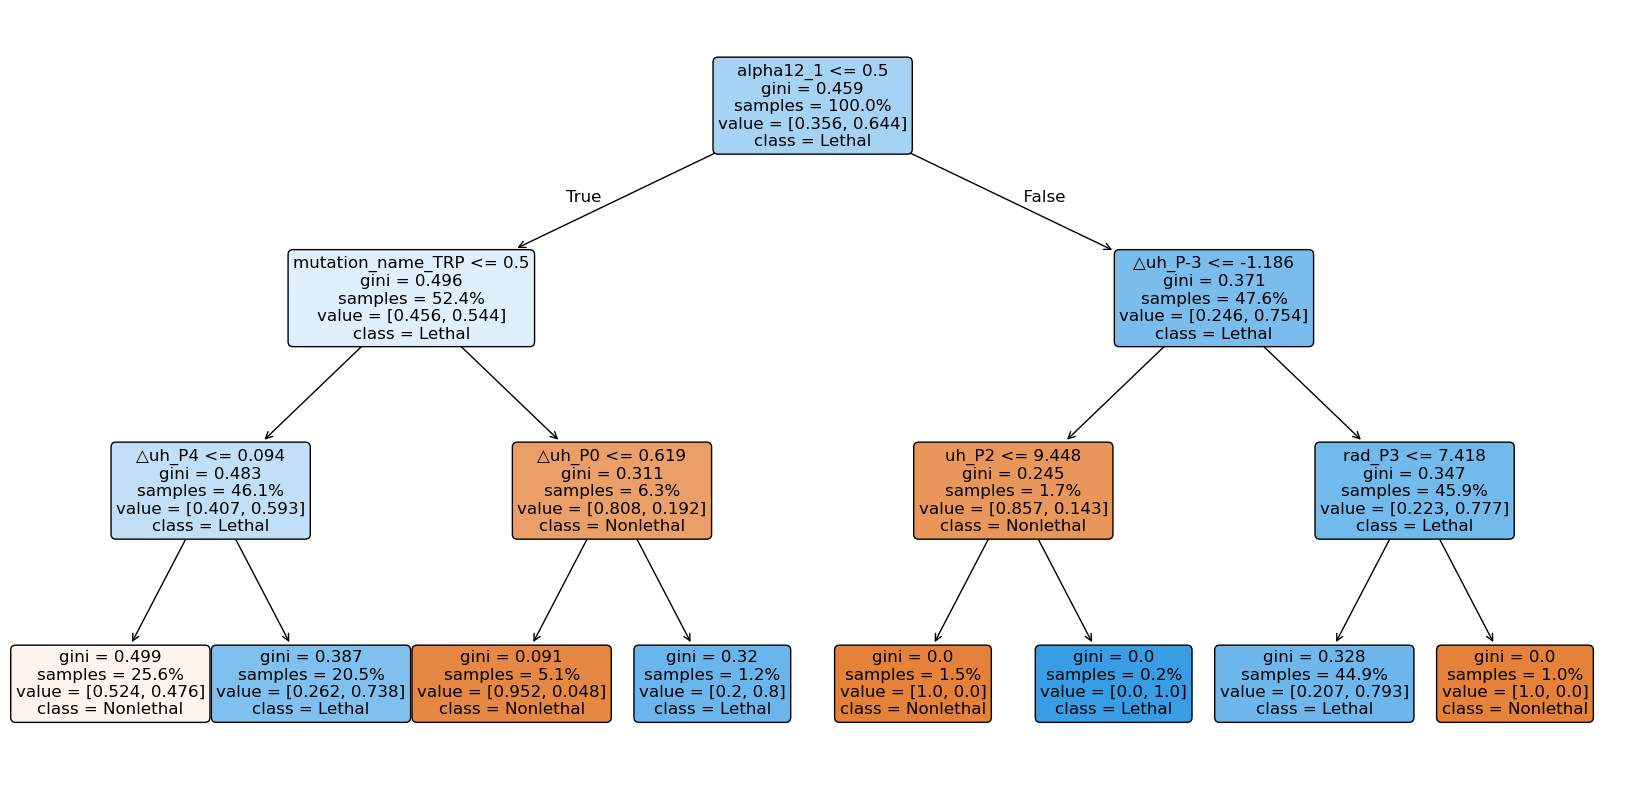


最佳參數: {'clf__max_depth': 3, 'clf__min_samples_leaf': 1}
最佳 CV 分數: 0.609908735332464


In [21]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 1) 讀資料 - 換成你的路徑
df = pd.read_excel(r"D:\collagen\decision_tree\01collagen\mutation_dataset.xlsx")

# 2) 準備特徵與標籤
#   - 你有四大區塊: rad_P-4..P4, uh_P-4..P4, △rad_P-4..P4, △uh_P-4..P4
#   - 自動抓取欄名，避免手動列舉出錯
num_prefixes = ["rad_P", "uh_P", "△rad_P", "△uh_P"]
num_cols = [c for c in df.columns if any(c.startswith(p) for p in num_prefixes)]

cat_cols = ["mutation_name", "alpha12", "triplet_number"]  # 你也可只放前兩者
label_col = "lethal"

X = df[num_cols + cat_cols].copy()
y = df[label_col].astype(int)

# 3) 類別與數值前處理
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))  # NaN 用中位數補
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

# 4) 建立模型流水線
#    可選參數: class_weight="balanced" 應對類別不平衡
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
pipe = Pipeline(steps=[("prep", preprocess),
                      ("clf", clf)])

# 5) 訓練-測試切分
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y  # 保持致死/非致死比例
)

# 6) 訓練
pipe.fit(X_train, y_train)

# 7) 評估
y_pred = pipe.predict(X_test)
print("測試集準確率:", accuracy_score(y_test, y_pred))
print("\n混淆矩陣:")
print(confusion_matrix(y_test, y_pred))
print("\n分類報告:")
print(classification_report(y_test, y_pred, target_names=["Nonlethal","Lethal"]))

# 8) 交叉驗證
scores = cross_val_score(pipe, X, y, cv=5)
print("\n5-fold 交叉驗證準確率:", scores)
print("平均準確率:", scores.mean())

# 9) 決策樹視覺化
#    需要拿到 one-hot 後的特徵名稱，才能畫出對應欄位
#    先把前處理器擬合在整體 X 以取得欄名
preprocess.fit(X)
# 數值欄名
num_feature_names = num_cols
# 類別欄名（展開 one-hot）
onehot = preprocess.named_transformers_["cat"].named_steps["onehot"]
cat_feature_names = onehot.get_feature_names_out(cat_cols).tolist()
feature_names_all = num_feature_names + cat_feature_names

# 從 pipe 取出已訓練好的樹
tree = pipe.named_steps["clf"]

plt.figure(figsize=(16.5, 8))
plot_tree(
    tree,
    feature_names=feature_names_all,
    class_names=["Nonlethal","Lethal"],
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=12
)
plt.tight_layout()
plt.show()

# 10) 超參數微調 - 可選
#     例如試 max_depth, min_samples_leaf
param_grid = {
    "clf__max_depth": [3, 4, 5, 6, None],
    "clf__min_samples_leaf": [1, 5, 10, 20],
}
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X, y)
print("\n最佳參數:", grid.best_params_)
print("最佳 CV 分數:", grid.best_score_)
